In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install transformers

import pandas as pd
import numpy as np
# from transformers import AutoTokenizer, RobertaForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
# df = pd.read_csv(r'/content/drive/MyDrive/IEMOCAP_DataFrame.csv')
df = pd.read_csv(r'/content/drive/MyDrive/IEMOCAP_Full.csv')

df_emotion = df[df['Emotion'].isin(['neu', 'ang', 'sad', 'hap'])]

convention = { "neu":0, "ang":1, "sad":2, "hap":3}
df_emotion.loc[df["Emotion"] == "neu", "Emotion"] = 0
df_emotion.loc[df["Emotion"] == "ang", "Emotion"] = 1
df_emotion.loc[df["Emotion"] == "sad", "Emotion"] = 2
df_emotion.loc[df["Emotion"] == "hap", "Emotion"] = 3

dataset = df_emotion[['Text', 'Emotion']]

dummies = pd.get_dummies(dataset['Emotion'])
dataset['Labels'] = dummies.values.tolist()
dataset

,Text,Emotion,Labels


In [ ]:
train_df = pd.read_csv(r'/content/drive/MyDrive/NLP Group/Final Dataset/train.csv')
test_df = pd.read_csv(r'/content/drive/MyDrive/NLP Group/Final Dataset/test.csv')

train_dataset = train_df.loc[:,['Text', 'Emotion']]
test_dataset = test_df.loc[:,['Text', 'Emotion']]

train_dummies = pd.get_dummies(train_dataset['Emotion'])
test_dummies = pd.get_dummies(test_dataset['Emotion'])

train_dataset['Labels'] = train_dummies.values.tolist()
test_dataset['Labels'] = test_dummies.values.tolist()

train_dataset

,Text,Emotion,Labels
0,Swine.,1,"[0, 1, 0, 0]"
1,No.,2,"[0, 0, 1, 0]"
2,Everybody's going to come up. We're going to s...,3,"[0, 0, 0, 1]"
3,No.,2,"[0, 0, 1, 0]"
4,About four this morning. I heard it crack and...,2,"[0, 0, 1, 0]"
...,...,...,...
3587,That's right. That's right. I mean he would ...,2,"[0, 0, 1, 0]"
3588,Just about all.,2,"[0, 0, 1, 0]"
3589,"Hey, I'm, uh. I'm really sorry about what happ...",2,"[0, 0, 1, 0]"
3590,Sara and I--,3,"[0, 0, 0, 1]"


In [ ]:
! pip install contractions --quiet
import contractions
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')

def preprocess(dataset):
  df_data = dataset.copy()
  ## pre-processing
  # Before data cleaning length
  before_data_cleaning = df_data['Text'].str.len().mean()

  # Remove blank rows
  df_data['Text'].dropna(inplace=True)
  # Remove numbers
  df_data['Text'] = df_data['Text'].apply(lambda x: re.sub(r'\d+', '', str(x)))
  # Converting to lower case
  # df_data['Text'] = df_data['Text'].apply(str.lower)
  # Remove punctuation
  df_data['Text'] = df_data['Text'].apply(lambda x: re.sub(r'[^\w\s\']', ' ', x))
  # Remove white spaces
  df_data['Text'] = df_data['Text'].apply(str.strip)
  # Removing contractions
  # def expand(text):
  #   return contractions.fix(text)
  # df_data['Text'] = df_data['Text'].apply(expand)

  # After data cleaning length
  after_data_cleaning = df_data['Text'].str.len().mean()

  print("Before cleaning : " + str(before_data_cleaning) + ", After cleaning : " + str(after_data_cleaning))

  ## stop word removal
  # stop = stopwords.words('english')
  # df_data['Text'] = df_data['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

  ## tokenization/lemmatization
  # w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
  # lemmatizer = nltk.stem.WordNetLemmatizer()
  # def lemmatize_text(text):
  #     return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
  # df_data['Text'] = df_data['Text'].apply(lemmatize_text)
  # df_data['Text'] = df_data['Text'].apply(lambda x: ' '.join([word for word in x]))

  return df_data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 15.4 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
train_dataset, test_dataset = train_test_split(df_data, test_size=0.2, shuffle = True)

In [ ]:
train_dataset, test_dataset = preprocess(train_dataset), preprocess(test_dataset)

Before cleaning : 57.31430957683742, After cleaning : 56.257516703786195
Before cleaning : 53.9086859688196, After cleaning : 52.88307349665924


In [ ]:
class LabeledDataset(Dataset):
  def __init__(self, dataset, tokenizer):
    tokenized_dataset = tokenizer(dataset['Text'].tolist(), padding=True, truncation=True, return_tensors='pt')
    self.input_ids = tokenized_dataset['input_ids']
    # self.token_type_ids = tokenized_dataset['token_type_ids']
    self.attention_mask = tokenized_dataset['attention_mask']
    self.labels = dataset['Labels'].values

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return {
        'ids': self.input_ids[idx],
        'mask': self.attention_mask[idx],
        # 'token_type_ids': self.token_type_ids[idx],
        'targets': torch.tensor(self.labels[idx], dtype=torch.float)
    }

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

labeled_dataset_train = LabeledDataset(train_dataset, tokenizer)
labeled_dataset_test = LabeledDataset(test_dataset, tokenizer)
train_dataloader = DataLoader(labeled_dataset_train, shuffle=True, batch_size=8)
test_dataloader = DataLoader(labeled_dataset_test, shuffle=False, batch_size=1)

In [ ]:
print(torch.cuda.is_available())
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

True


In [ ]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels, avg='weighted'):
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = np.argmax(labels, axis=1).flatten()
  return f1_score(labels_flat, preds_flat, average=avg)
  
def accuracy_func(preds, labels):
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = np.argmax(labels, axis=1).flatten()
  score = [p == l for p, l in zip(preds_flat, labels_flat)]
  return sum(score)/len(score)

In [ ]:
preds = []

x = np.ndarray((32, 4))
preds.append(x)
preds = np.array(preds)
preds
# preds.flatten()

array([[[6.72190382e-316, 0.00000000e+000, 6.90379951e-310,
         6.90379951e-310],
        [6.90379951e-310, 6.90379951e-310, 6.90379951e-310,
         6.90379951e-310],
        [6.90379951e-310, 6.90379951e-310, 6.90379951e-310,
         6.90379951e-310],
        [6.90379951e-310, 6.90379951e-310, 6.90379951e-310,
         6.90379951e-310],
        [6.90379951e-310, 6.90379951e-310, 6.90379951e-310,
         6.90379951e-310],
        [6.90379951e-310, 6.90379951e-310, 6.90379951e-310,
         6.90379951e-310],
        [6.90379951e-310, 6.90379951e-310, 6.90379951e-310,
         6.90379951e-310],
        [6.90379951e-310, 6.90379951e-310, 6.90379951e-310,
         6.90379951e-310],
        [6.90379951e-310, 6.90379951e-310, 6.90379951e-310,
         6.90379951e-310],
        [6.90379951e-310, 6.90379951e-310, 6.90379951e-310,
         6.90379951e-310],
        [6.90379951e-310, 6.90379951e-310, 6.90379951e-310,
         6.90379951e-310],
        [6.90379951e-310, 6.90379951e-310, 

In [ ]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=4)
# optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
epochs = 25

model.to(device)

f1s = [0.0]
accs = [0.0]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [ ]:
for epoch in range(epochs):
  model.train()
  for _, data in enumerate(train_dataloader, 0):
    model.zero_grad()

    ids = data['ids'].to(device, dtype = torch.long)
    mask = data['mask'].to(device, dtype = torch.long)
    # token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
    targets = data['targets'].to(device, dtype = torch.float)


    inputs = {'input_ids':      ids,
              'attention_mask': mask,
              'labels':         targets,
              }
    outputs = model(**inputs)

    loss = outputs[0]
    loss.backward()
    if _%5000==0:
        print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
    optimizer.step()
  
  model.eval()

  loss_val_total = 0
  predictions, true_vals = [], []

  for _, data in enumerate(test_dataloader, 0):
      
    ids = data['ids'].to(device, dtype = torch.long)
    mask = data['mask'].to(device, dtype = torch.long)
    # token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
    targets = data['targets'].to(device, dtype = torch.float)


    inputs = {'input_ids':      ids,
              'attention_mask': mask,
              'labels':         targets,
              }
    outputs = model(**inputs)

    with torch.no_grad():        
        outputs = model(**inputs)
        
    loss = outputs[0]
    logits = outputs[1]
    loss_val_total += loss.item()

    logits = logits.detach().cpu().numpy()
    label_ids = inputs['labels'].cpu().numpy()
    predictions.append(logits)
    true_vals.append(label_ids)

  predictions = np.concatenate(predictions, axis=0)
  true_vals = np.concatenate(true_vals, axis=0)
  f1 = f1_score_func(predictions, true_vals)
  acc = accuracy_func(predictions, true_vals)
  if acc > max(accs):
    torch.save(model.state_dict(), f'roberta_{acc:.6f}.pt')
  print(f'validation f1 score: {f1}')
  print(f'validation macro f1: {f1_score_func(predictions, true_vals, "macro")}')
  print(f'validation accuracy: {acc}\n')
  f1s.append(f1)
  accs.append(acc)

Epoch: 0, Loss:  0.04391450807452202
validation f1 score: 0.6923575771626425
validation macro f1: 0.6827919693518062
validation accuracy: 0.6937639198218263

Epoch: 1, Loss:  0.1788213700056076
validation f1 score: 0.6936604373654924
validation macro f1: 0.687346314033778
validation accuracy: 0.6937639198218263

Epoch: 2, Loss:  0.254561185836792
validation f1 score: 0.688839141560756
validation macro f1: 0.6829638954262676
validation accuracy: 0.6893095768374164

Epoch: 3, Loss:  0.17427286505699158
validation f1 score: 0.6845314557397143
validation macro f1: 0.6749068914158176
validation accuracy: 0.6859688195991092

Epoch: 4, Loss:  0.140640527009964
validation f1 score: 0.6814807257745843
validation macro f1: 0.674563579579425
validation accuracy: 0.6826280623608018

Epoch: 5, Loss:  0.028879059478640556
validation f1 score: 0.6782282610228562
validation macro f1: 0.6717544423183878
validation accuracy: 0.6792873051224945

Epoch: 6, Loss:  0.08767233788967133
validation f1 score: 0

In [ ]:
f1_score_func(predictions, true_vals, 'macro')

0.6881938741307091

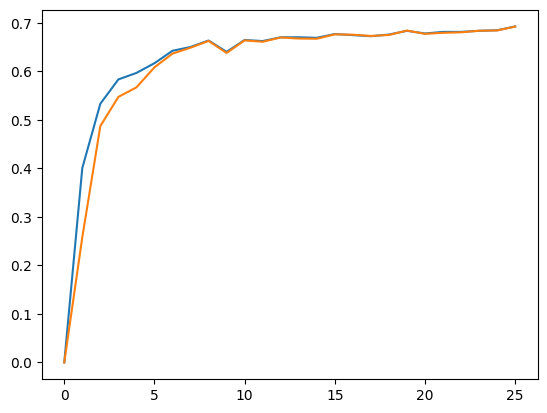

In [ ]:
import matplotlib.pyplot as plt

plt.plot(accs)
plt.plot(f1s)

In [ ]:
f'roberta_{acc:.6f}.pt'

'roberta_0.576159.pt'